# 再帰型ニューラルネットワーク（RNN）とは

データが一方向だけに進む（**フィードフォワード**）構造と異なり、ループする構造を持つ。ループを展開したイメージが以下。<br>
出力$\mathrm{h}_{t}$は**隠れ状態**（hidden state）や**隠れ状態ベクトル**（hidden state vector）と呼ばれ、「状態」が1単位ごとに更新される。

![](image/11_rnn.png)

## Truncated BPTT

RNNでの誤差逆伝播法は、時間方向に展開する意味で、**BPTT**（Backpropagation Through Time）と呼ばれる。<br>
BPTTでは、時間サイズが大きくなると逆伝播時の勾配が不安定になる問題や、各時刻の中間データを記憶するためメモリ使用量が増加する問題がある。<br><br>
そこで、ネットワークを適当な長さで切り、それぞれの小さなネットワークに対して誤差逆伝播法を行う**Truncated BPTT**が有効。

![](image/11_truncated-bptt.png)
それぞれのブロックの計算には、前ブロックの最後の隠れ状態を使うため、**順伝播のつながりは維持される**。

## ミニバッチ学習

ミニバッチ学習は、各バッチの開始位置をオフセットとしてずらし、データをシーケンシャルに与えることで可能になる。

# RNNの実装

![](image/11_time-rnn.png)
$T$個のRNNレイヤを連結したネットワークをTime RNNレイヤとする。<br>
RNNの1ステップの処理をRNNクラスで実装、そして$T$ステップの処理をまとめて行うレイヤをTimeRNNクラスとして実装する。

## RNNレイヤの実装

![](image/11_rnn-layer.png)

RNNレイヤで行う計算は以下の数式で表されるもの。
$$\mathrm{h}_{t}=\tanh \left( \mathrm{h}_{t-1}\mathrm{W}_{\mathrm{h}}+\mathrm{x}_{t}\mathrm{W}_{\mathrm{x}}+\mathrm{b}\right)$$
$\mathrm{h}_{t-1}$　：時刻$t-1$における出力　$(N\times H)$<br>
$\mathrm{W}_{\mathrm{h}}$：出力を次時刻の出力に変換するための重み　$(H\times H)$<br>
$\mathrm{x}_{t}$　：時刻$t$における出力　$(N\times D)$<br>
$\mathrm{W}_{\mathrm{x}}$：入力$\mathrm{x}$を出力$\mathrm{h}$ に変換するための重み　$(D\times H)$<br>
$\mathrm{b}$　：バイアス　(ブロードキャスト)<br>
$\mathrm{h}_{t}$　：時刻$t$における出力　$(N\times H)$<br>

In [2]:
class RNN:
    def __init__(self, Wx, Wh, b): # 引数:重みWx、Wh、バイアス
        self.params = [Wx, Wh, b] # メンバ変数paramsにリストとして保存
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)] # 勾配を初期化しgradsに格納
        self.cache = None # 逆伝播の計算に使用する中間データをcacheとし、Noneで初期化
        
    def forward(self, x, h_prev): # 下からの入力x、前RNNレイヤから受け取る入力h_prev
        Wx, Wh, b = self.params
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b # 式の通り
        h_next = np.tanh(t) # 式の通り
        
        self.cache = (x, h_prev, h_next)
        return h_next # 現時刻の出力（=次時刻レイヤへの入力）
    
    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache
       
        dt = dh_next * (1 - h_next ** 2) # tanhレイヤ
        db = np.sum(dt, axis=0) # 加算レイヤ
        dWh = np.dot(h_prev.T, dt) # MaMulレイヤ
        dh_prev = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt) # MaMulレイヤ
        dx = np.dot(dt, Wx.T)
        
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        
        return dx, dh_prev

## TimeRNNレイヤの実装

In [3]:
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None # RNNレイヤをリストで保持
        
        self.h = None # forward()時の最後のRNNレイヤの隠れ状態を保持
        self.dh = None # backward()時のひとつ前のブロックへの隠れ状態の勾配を保持
        self.stateful = stateful
        
    def set_state(self,h): # 隠れ状態を設定
        self.h = h
        
    def reset_state(self): # 隠れ状態をリセット
        self.h = None
        
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape # バッチサイズN、時系列データの数T、入力ベクトルの次元数D → 形状(N, T, D)
        D, H = Wx.shape
        
        self.layers = []
        hs = np.empty((N, T, H), dtype='f')
        
        if not self.stateful or self.h is None: # 初回呼び出し時（self.hがNone）、メンバ変数statefulがFalseの場合
            self.h = np.zeros((N, H), dtype='f') # hをゼロ行列でリセット
            
        for t in range(T): # T回RNNレイヤ
            layer = RNN(*self.params) # RNNレイヤ生成
            self.h = layer.forward(xs[:, t, :], self.h) # 隠れ状態を計算
            hs[:, t, :] = self.h # hsの該当するインデックス（時刻）に設定
            self.layers.append(layer) # メンバ変数layersに追加
            
        return hs
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape # バッチサイズN、時系列データの数T、隠れ状態ベクトルの次元数H → 形状(N, T, H)
        D, H = Wx.shape
        
        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)): # 順伝播とは逆順
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh) # 合算した勾配
            dxs[:, t, :] = dx # 該当するインデックスに代入
            
            for i, grad in enumerate(layer.grads):
                grads[i] += grad # 各RNNレイヤの重みの勾配を加算
                
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad # 最終的な結果を上書き
        self.dh = dh
        
        return dxs

# RNNLMの実装

RNNによる言語モデルを実装する。
![](image/11_rnnlm.png)

## Timeレイヤの実装

TimeEmbeddingレイヤとTimeAffineレイヤはレイヤを$T$個だけ用意し、個別に処理するだけ。<br>
TimeSoftmaxWithLossレイヤでは、$L=\dfrac{1}{T}\left( L_{0}+L_{1}+\ldots +L_{T-1}\right)$の通り、それぞれの損失の平均を計算。

In [4]:
from source.common02.layers import Embedding, softmax

In [5]:
class TimeEmbedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.layers = None
        self.W = W

    def forward(self, xs):
        N, T = xs.shape
        V, D = self.W.shape

        out = np.empty((N, T, D), dtype='f')
        self.layers = []

        for t in range(T):
            layer = Embedding(self.W)
            out[:, t, :] = layer.forward(xs[:, t])
            self.layers.append(layer)

        return out

    def backward(self, dout):
        N, T, D = dout.shape

        grad = 0
        for t in range(T):
            layer = self.layers[t]
            layer.backward(dout[:, t, :])
            grad += layer.grads[0]

        self.grads[0][...] = grad
        return None

In [6]:
class TimeAffine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        N, T, D = x.shape
        W, b = self.params

        rx = x.reshape(N*T, -1)
        out = np.dot(rx, W) + b
        self.x = x
        return out.reshape(N, T, -1)

    def backward(self, dout):
        x = self.x
        N, T, D = x.shape
        W, b = self.params

        dout = dout.reshape(N*T, -1)
        rx = x.reshape(N*T, -1)

        db = np.sum(dout, axis=0)
        dW = np.dot(rx.T, dout)
        dx = np.dot(dout, W.T)
        dx = dx.reshape(*x.shape)

        self.grads[0][...] = dW
        self.grads[1][...] = db

        return dx

In [7]:
class TimeSoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        self.ignore_label = -1

    def forward(self, xs, ts):
        N, T, V = xs.shape

        if ts.ndim == 3:  # 教師ラベルがone-hotベクトルの場合
            ts = ts.argmax(axis=2)

        mask = (ts != self.ignore_label)

        # バッチ分と時系列分をまとめる（reshape）
        xs = xs.reshape(N * T, V)
        ts = ts.reshape(N * T)
        mask = mask.reshape(N * T)

        ys = softmax(xs)
        ls = np.log(ys[np.arange(N * T), ts])
        ls *= mask  # ignore_labelに該当するデータは損失を0にする
        loss = -np.sum(ls)
        loss /= mask.sum()

        self.cache = (ts, ys, mask, (N, T, V))
        return loss

    def backward(self, dout=1):
        ts, ys, mask, (N, T, V) = self.cache

        dx = ys
        dx[np.arange(N * T), ts] -= 1
        dx *= dout
        dx /= mask.sum()
        dx *= mask[:, np.newaxis]  # ignore_labelに該当するデータは勾配を0にする

        dx = dx.reshape((N, T, V))

        return dx

## SimpleRnnlmの実装

In [8]:
class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 重みの初期化　（RNNとAffineにおいてXavierの初期値を利用）
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # レイヤの生成
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]

        # すべての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.rnn_layer.reset_state()

## 言語モデルの評価

言語モデルの予測性能の評価の指標として、**パープレキシティ**（perplexity）がよく用いられる。<br>
パープレキシティは確率の逆数を表し、値は予測される候補の数と、直感的に解釈することができ、値が小さいほど良いモデルであることを示す。<br><br>
$$L=-\dfrac{1}{N}\sum _{n}\sum _{k}t_{nk}\log y_{nk}$$<br>
$$\mathrm{perplexity} =e^{L}$$
L：交差エントロピー誤差

## 学習の実装

Done
corpus size: 1000, vocabulary size: 418
| epoch 1 | perplexity 390.29
| epoch 2 | perplexity 269.46
| epoch 3 | perplexity 228.89
| epoch 4 | perplexity 217.69
| epoch 5 | perplexity 207.11
| epoch 6 | perplexity 203.10
| epoch 7 | perplexity 198.17
| epoch 8 | perplexity 196.35
| epoch 9 | perplexity 191.78
| epoch 10 | perplexity 192.21
| epoch 11 | perplexity 188.32
| epoch 12 | perplexity 191.93
| epoch 13 | perplexity 189.01
| epoch 14 | perplexity 190.23
| epoch 15 | perplexity 188.75
| epoch 16 | perplexity 185.39
| epoch 17 | perplexity 182.77
| epoch 18 | perplexity 179.50
| epoch 19 | perplexity 180.80
| epoch 20 | perplexity 181.39
| epoch 21 | perplexity 178.62
| epoch 22 | perplexity 176.83
| epoch 23 | perplexity 172.56
| epoch 24 | perplexity 171.46
| epoch 25 | perplexity 170.34
| epoch 26 | perplexity 169.00
| epoch 27 | perplexity 165.38
| epoch 28 | perplexity 161.89
| epoch 29 | perplexity 158.35
| epoch 30 | perplexity 152.74
| epoch 31 | perplexity 153.46
| e

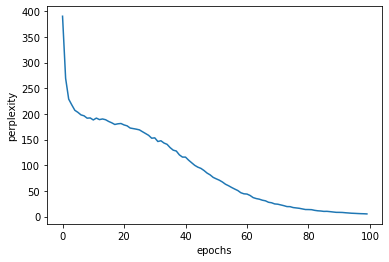

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from source.common02.optimizer import SGD
from source.dataset02 import ptb

# ハイパーパラメータの設定
batch_size = 10
wordvec_size = 100
hidden_size = 100 # 隠れ状態ベクトルの要素数
time_size = 5  # Truncated BPTTの展開する時間サイズ
lr = 0.1
max_epoch = 100

# 学習データの読み込み（データセットを小さくする）
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]  # 入力
ts = corpus[1:]  # 出力（教師ラベル）
data_size = len(xs)
print('corpus size: %d, vocabulary size: %d' % (corpus_size, vocab_size))

# 学習時に使用する変数
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# モデルの生成
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# ミニバッチの各サンプルの読み込み開始位置を計算
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # ミニバッチの取得
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size] # コーパスサイズで割った余り
                batch_t[i, t] = ts[(offset + time_idx) % data_size] # 読み込む場所がコーパスサイズを超えてしまう対策
            time_idx += 1

        # 勾配を求め、パラメータを更新
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # エポックごとにパープレキシティの評価
    ppl = np.exp(total_loss / loss_count)
    print('| epoch %d | perplexity %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

# グラフの描画
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()

最後の方では、パープレキシティが、最小値である1に近づいている。

## RnnlmTrainerの実装

RNNLMの学習の際、毎回同じような長いコードを書かずに済むように、以上の学習の処理をまとめる。

In [10]:
class RnnlmTrainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.time_idx = None
        self.ppl_list = None
        self.eval_interval = None
        self.current_epoch = 0

    def get_batch(self, x, t, batch_size, time_size):
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')

        data_size = len(x)
        jump = data_size // batch_size
        offsets = [i * jump for i in range(batch_size)]  # バッチの各サンプルの読み込み開始位置

        for time in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, time] = x[(offset + self.time_idx) % data_size]
                batch_t[i, time] = t[(offset + self.time_idx) % data_size]
            self.time_idx += 1
        return batch_x, batch_t

    def fit(self, xs, ts, max_epoch=10, batch_size=20, time_size=35,
            max_grad=None, eval_interval=20):
        data_size = len(xs)
        max_iters = data_size // (batch_size * time_size)
        self.time_idx = 0
        self.ppl_list = []
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            for iters in range(max_iters):
                batch_x, batch_t = self.get_batch(xs, ts, batch_size, time_size)

                # 勾配を求め、パラメータを更新
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 共有された重みを1つに集約
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # パープレキシティの評価
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    ppl = np.exp(total_loss / loss_count)
                    elapsed_time = time.time() - start_time
                    print('| epoch %d |  iter %d / %d | time %d[s] | perplexity %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, ppl))
                    self.ppl_list.append(float(ppl))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = numpy.arange(len(self.ppl_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.ppl_list, label='train')
        plt.xlabel('iterations (x' + str(self.eval_interval) + ')')
        plt.ylabel('perplexity')
        plt.show()

| epoch 1 |  iter 1 / 19 | time 0[s] | perplexity 417.23
| epoch 2 |  iter 1 / 19 | time 0[s] | perplexity 367.86
| epoch 3 |  iter 1 / 19 | time 0[s] | perplexity 254.64
| epoch 4 |  iter 1 / 19 | time 0[s] | perplexity 220.17
| epoch 5 |  iter 1 / 19 | time 0[s] | perplexity 209.94
| epoch 6 |  iter 1 / 19 | time 0[s] | perplexity 207.57
| epoch 7 |  iter 1 / 19 | time 0[s] | perplexity 199.92
| epoch 8 |  iter 1 / 19 | time 0[s] | perplexity 200.61
| epoch 9 |  iter 1 / 19 | time 0[s] | perplexity 194.39
| epoch 10 |  iter 1 / 19 | time 0[s] | perplexity 190.78
| epoch 11 |  iter 1 / 19 | time 0[s] | perplexity 192.92
| epoch 12 |  iter 1 / 19 | time 0[s] | perplexity 190.06
| epoch 13 |  iter 1 / 19 | time 0[s] | perplexity 192.31
| epoch 14 |  iter 1 / 19 | time 0[s] | perplexity 187.74
| epoch 15 |  iter 1 / 19 | time 0[s] | perplexity 186.93
| epoch 16 |  iter 1 / 19 | time 0[s] | perplexity 189.58
| epoch 17 |  iter 1 / 19 | time 0[s] | perplexity 189.54
| epoch 18 |  iter 1 / 

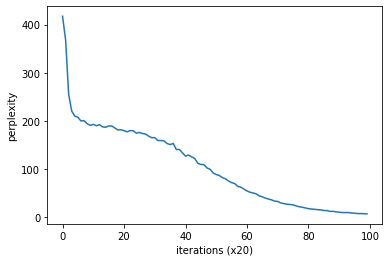

In [11]:
from source.common02.optimizer import SGD
from source.common02.trainer import RnnlmTrainer
from source.dataset02 import ptb

# ハイパーパラメータの設定
batch_size = 10
wordvec_size = 100
hidden_size = 100  # RNNの隠れ状態ベクトルの要素数
time_size = 5  # RNNを展開するサイズ
lr = 0.1
max_epoch = 100

# 学習データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000  # テスト用にデータセットを小さくする
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)
xs = corpus[:-1]  # 入力
ts = corpus[1:]  # 出力（教師ラベル）

# モデルの生成
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size)
trainer.plot()